## Paquetes

In [3]:
# warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import openpyxl
from tqdm import tqdm
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
from operator import itemgetter
import seaborn as sns

import pandas as pd
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels.panel import compare
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from linearmodels import OLS

## Procesamiento de datos

In [5]:
alc = pd.read_excel("ALCALDIAS_FINAL.xlsx")
alc19 = alc[alc.date==2019]
alc19 = alc19.drop(columns=["date", "municipio", "dpto"])

In [6]:
poblacion = pd.read_stata("CEDE//poblacion.dta")
poblacion.columns = ["dane", "dpto", "municipio", "date", "population"]

In [7]:
deuda = pd.read_excel("DEUDA.xlsx")
deuda = deuda[['id', 'entidad', 'tipo_entidad', 'id_dpt', 'año',
       'saldo_deuda($) ']]
deuda.columns = ["dane", "entidad", "tipo", "id_dpto", "date", "deuda"]
# deuda = deuda[deuda.deuda>0]

### Regresiones

Integrantes

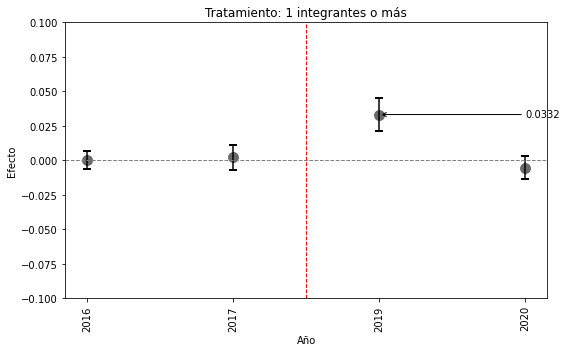

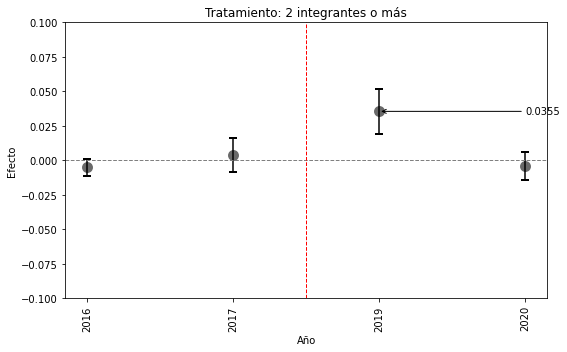

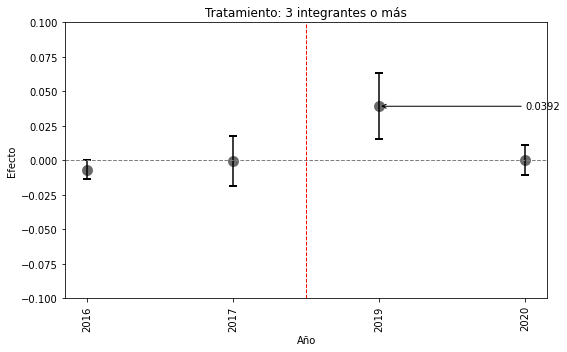

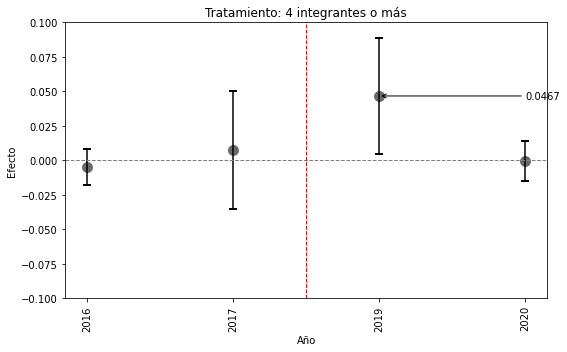

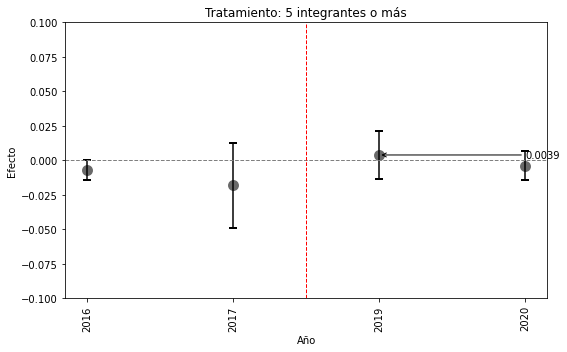

In [319]:
for miembros in [1,2,3,4,5]:
 
    df = pd.merge(deuda, poblacion, "inner", ["dane", "date"])
    df = pd.merge(df, alc19, "left", ["dane"])
    df["deuda_pc"] = df["deuda"] / df["population"]

    df['diferencia'] = df['proporcion_primero'] - df['proporcion_segundo']
    df["post"] = df["date"].map(lambda x: 1 if x >= 2019 else 0)
    df = df.drop(df[(df['rep_tl1'] == 1) & (df['rept'] == 1)].index)

    df["treated"] = 0
    df.loc[(df['rept'] == 1) & (df['numero_integrantest'] >= miembros) & (df['rep_tl1'] == 0), 'treated'] = 1
    df['treated_post'] = df['treated'] * df['post']
    df["post_1"] = df["date"].map(lambda x: 1 if x >= 2018 else 0)
    df['treated_post_1'] = df['treated'] * df['post_1']
    df["post_2"] = df["date"].map(lambda x: 1 if x >= 2017 else 0)
    df['treated_post_2'] = df['treated'] * df['post_2']
    df["post_3"] = df["date"].map(lambda x: 1 if x >= 2016 else 0)
    df['treated_post_3'] = df['treated'] * df['post_3']
    df["post_f1"] = df["date"].map(lambda x: 1 if x >= 2020 else 0)
    df['treated_post_f1'] = df['treated'] * df['post_f1']

    df = df[df["deuda"].notna()]

    df = df.set_index(['dane', 'date'])

    model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post_3 + treated_post_2 + treated_post + treated_post_f1 + EntityEffects', data=df)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    variables = ['treated_post_3', 'treated_post_2', 'treated_post', 'treated_post_f1']

    params = result.params.loc[variables]
    std_errors = result.std_errors.loc[variables]

    ci_lower = params - 1.65 * std_errors
    ci_upper = params + 1.65 * std_errors

    results_df = pd.DataFrame({
        'coef': params,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }, index=variables)

    results_df = results_df.rename(columns={'coef': 'T', 'ci_lower': 'II', 'ci_upper': 'IS'})

    results_df.index = ['2016', '2017', '2019', '2020']


    fig, ax = plt.subplots(1, 1, figsize=(8, 5)) 

    tupla_n = list(zip(results_df.II, results_df.IS))

    sns.scatterplot(x=results_df.index, y=results_df.II, color="black", marker="_", s=80, edgecolor='black', linewidth=2)
    sns.scatterplot(x=results_df.index, y=results_df.IS, color="black", marker="_", s=80, edgecolor='black', linewidth=2)

    for i, (lower, upper) in enumerate(tupla_n):
        ax.plot([i, i], [lower, upper], color='black')

    sns.scatterplot(x=results_df.index, y=results_df["T"], color="dimgray", marker="o", s=80, edgecolor='dimgray', linewidth=2)

    coef_2019 = results_df.loc['2019', 'T']
    ax.annotate(f'{coef_2019:.4f}', xy=(2, coef_2019), xytext=(3, coef_2019),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='center')

    ax.axhline(0, color='gray', linestyle='--', lw=1)
    ax.axvline(1.5, color='red', linestyle='--', lw=1)

    ax.set_ylim(-0.1, 0.1)

    plt.title(f"Tratamiento: {miembros} integrantes o más")

    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df.index, rotation=90)
    plt.xlabel("Año")
    plt.ylabel("Efecto")

    plt.savefig(f"Tratamiento {miembros} integrantes o más.jpeg", dpi =300)

    plt.tight_layout()
    plt.show()

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

miembros_list = [1, 2, 3, 4, 5]
result_table = pd.DataFrame()

for miembros in miembros_list:

    df = pd.merge(deuda, poblacion, "inner", ["dane", "date"])
    df = pd.merge(df, alc19, "left", ["dane"])
    df["deuda_pc"] = df["deuda"] / df["population"]

    df['diferencia'] = df['proporcion_primero'] - df['proporcion_segundo']
    df["post"] = df["date"].map(lambda x: 1 if x >= 2019 else 0)
    df = df.drop(df[(df['rep_tl1'] == 1) & (df['rept'] == 1)].index)

    df["treated"] = 0
    df.loc[(df['rept'] == 1) & (df['numero_integrantest'] >= miembros) & (df['rep_tl1'] == 0), 'treated'] = 1
    df['treated_post'] = df['treated'] * df['post']
    df["post_1"] = df["date"].map(lambda x: 1 if x >= 2018 else 0)
    df['treated_post_1'] = df['treated'] * df['post_1']
    df["post_2"] = df["date"].map(lambda x: 1 if x >= 2017 else 0)
    df['treated_post_2'] = df['treated'] * df['post_2']
    df["post_3"] = df["date"].map(lambda x: 1 if x >= 2016 else 0)
    df['treated_post_3'] = df['treated'] * df['post_3']
    df["post_f1"] = df["date"].map(lambda x: 1 if x >= 2020 else 0)
    df['treated_post_f1'] = df['treated'] * df['post_f1']

    df = df[df["deuda"].notna()]

    df = df.set_index(['dane', 'date'])

    model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post_3 + treated_post_2 + treated_post + treated_post_f1 + EntityEffects', data=df)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    variables = ['treated_post_3', 'treated_post_2', 'treated_post', 'treated_post_f1']

    params = result.params.loc[variables]
    std_errors = result.std_errors.loc[variables]
    p_values = result.pvalues.loc[variables]

    ci_lower = params - 1.65 * std_errors
    ci_upper = params + 1.65 * std_errors

    coef_data = {}
    for variable in variables:
        coef = params.loc[variable]
        error = std_errors.loc[variable]
        p_value = p_values.loc[variable]
        stars = ''
        if p_value < 0.1:
            stars = '*'
        if p_value < 0.05:
            stars = '**'
        if p_value < 0.01:
            stars = '***'
        coef_data[f'Coeficiente {variable} (Error)'] = f'{coef:.4f} ({error:.4f}) {stars}'
    
    coef_data['F Estadístico Robusto'] = result.f_statistic_robust.stat
    coef_data['R2'] = result.rsquared*300
    coef_data['N'] = result.nobs
    
    result_table = result_table.append(coef_data, ignore_index=True)

result_table['Tratamiento'] = [f"{miembros} integrantes o más" for miembros in miembros_list]
result_table = result_table.set_index('Tratamiento')

result_table.T

result_table.T.to_excel("VARIACIÓN_miembros.xlsx")

Variación sobre diferencia de votación

In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

miembros_list = np.arange(0.1,0.8,0.1)
result_table = pd.DataFrame()

for miembros in miembros_list:

    df = pd.merge(deuda, poblacion, "inner", ["dane", "date"])
    df = pd.merge(df, alc19, "left", ["dane"])
    df["deuda_pc"] = df["deuda"] / df["population"]

    df['diferencia'] = df['proporcion_primero'] - df['proporcion_segundo']
    df = df[df["diferencia"]<miembros]
    df["post"] = df["date"].map(lambda x: 1 if x >= 2019 else 0)
    df = df.drop(df[(df['rep_tl1'] == 1) & (df['rept'] == 1)].index)

    df["treated"] = 0
    df.loc[(df['rept'] == 1) & (df['numero_integrantest'] >= 1) & (df['rep_tl1'] == 0), 'treated'] = 1
    df['treated_post'] = df['treated'] * df['post']
    df["post_1"] = df["date"].map(lambda x: 1 if x >= 2018 else 0)
    df['treated_post_1'] = df['treated'] * df['post_1']
    df["post_2"] = df["date"].map(lambda x: 1 if x >= 2017 else 0)
    df['treated_post_2'] = df['treated'] * df['post_2']
    df["post_3"] = df["date"].map(lambda x: 1 if x >= 2016 else 0)
    df['treated_post_3'] = df['treated'] * df['post_3']
    df["post_f1"] = df["date"].map(lambda x: 1 if x >= 2020 else 0)
    df['treated_post_f1'] = df['treated'] * df['post_f1']

    df = df[df["deuda"].notna()]

    df = df.set_index(['dane', 'date'])

    model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post_3 + treated_post_2 + treated_post + treated_post_f1 + EntityEffects', data=df)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    variables = ['treated_post_3', 'treated_post_2', 'treated_post', 'treated_post_f1']

    params = result.params.loc[variables]
    std_errors = result.std_errors.loc[variables]
    p_values = result.pvalues.loc[variables]

    ci_lower = params - 1.65 * std_errors
    ci_upper = params + 1.65 * std_errors

    coef_data = {}
    for variable in variables:
        coef = params.loc[variable]
        error = std_errors.loc[variable]
        p_value = p_values.loc[variable]
        stars = ''
        if p_value < 0.1:
            stars = '*'
        if p_value < 0.05:
            stars = '**'
        if p_value < 0.01:
            stars = '***'
        coef_data[f'Coeficiente {variable} (Error)'] = f'{coef:.4f} ({error:.4f}) {stars}'
    
    coef_data['F Estadístico Robusto'] = result.f_statistic_robust.stat
    coef_data['R2'] = result.rsquared*300
    coef_data['N'] = result.nobs
    
    result_table = result_table.append(coef_data, ignore_index=True)

result_table['Tratamiento'] = [f"{round(miembros,4)} de diferencia" for miembros in miembros_list]
result_table = result_table.set_index('Tratamiento')

result_table.T.to_excel("VARIACIÓN_diferencia.xlsx")

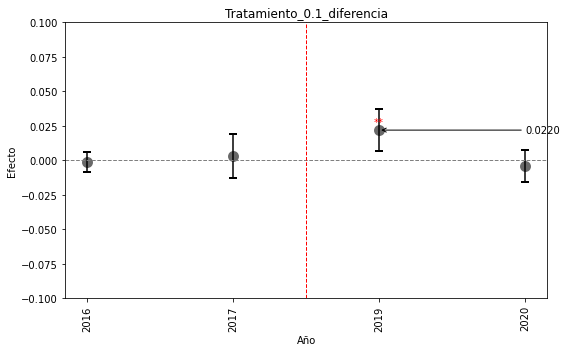

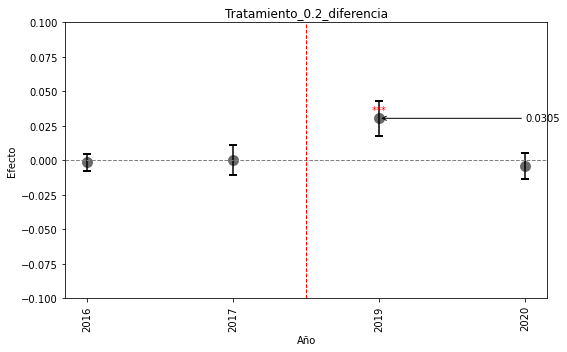

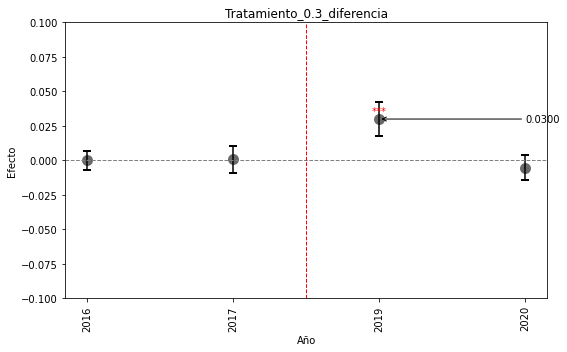

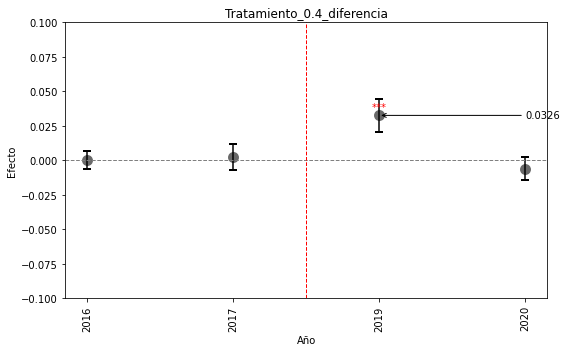

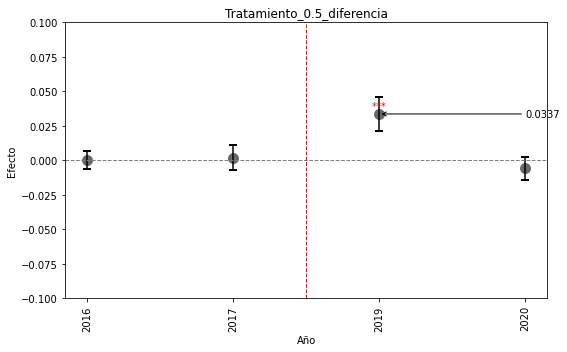

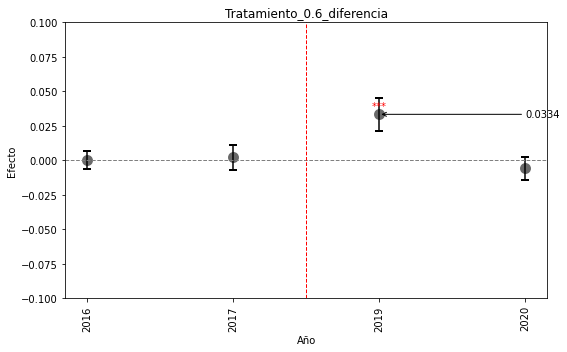

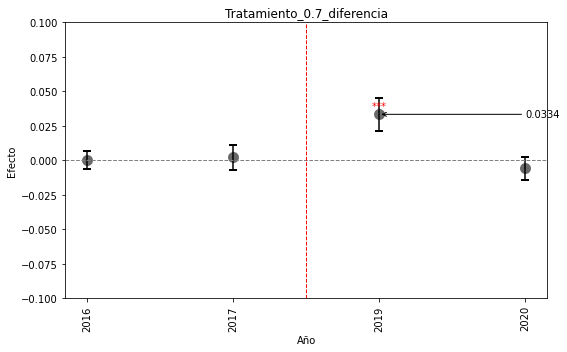

In [325]:
miembros_list = np.arange(0.1,0.8,0.1)

for miembros in miembros_list:

    df = pd.merge(deuda, poblacion, "inner", ["dane", "date"])
    df = pd.merge(df, alc19, "left", ["dane"])
    df["deuda_pc"] = df["deuda"] / df["population"]

    df['diferencia'] = df['proporcion_primero'] - df['proporcion_segundo']
    df["post"] = df["date"].map(lambda x: 1 if x >= 2019 else 0)
    df = df[df["diferencia"]<miembros]
    df = df.drop(df[(df['rep_tl1'] == 1) & (df['rept'] == 1)].index)

    df["treated"] = 0
    df.loc[(df['rept'] == 1) & (df['numero_integrantest'] >= miembros) & (df['rep_tl1'] == 0), 'treated'] = 1
    df['treated_post'] = df['treated'] * df['post']
    df["post_1"] = df["date"].map(lambda x: 1 if x >= 2018 else 0)
    df['treated_post_1'] = df['treated'] * df['post_1']
    df["post_2"] = df["date"].map(lambda x: 1 if x >= 2017 else 0)
    df['treated_post_2'] = df['treated'] * df['post_2']
    df["post_3"] = df["date"].map(lambda x: 1 if x >= 2016 else 0)
    df['treated_post_3'] = df['treated'] * df['post_3']
    df["post_f1"] = df["date"].map(lambda x: 1 if x >= 2020 else 0)
    df['treated_post_f1'] = df['treated'] * df['post_f1']

    df = df[df["deuda"].notna()]

    df = df.set_index(['dane', 'date'])

    model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post_3 + treated_post_2 + treated_post + treated_post_f1 + EntityEffects', data=df)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    variables = ['treated_post_3', 'treated_post_2', 'treated_post', 'treated_post_f1']

    params = result.params.loc[variables]
    std_errors = result.std_errors.loc[variables]
    p_values = result.pvalues.loc[variables]

    ci_lower = params - 1.65 * std_errors
    ci_upper = params + 1.65 * std_errors

    results_df = pd.DataFrame({
        'coef': params,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }, index=variables)

    results_df = results_df.rename(columns={'coef': 'T', 'ci_lower': 'II', 'ci_upper': 'IS'})

    results_df.index = ['2016', '2017', '2019', '2020']

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    tupla_n = list(zip(results_df.II, results_df.IS))

    sns.scatterplot(x=results_df.index, y=results_df.II, color="black", marker="_", s=80, edgecolor='black', linewidth=2)
    sns.scatterplot(x=results_df.index, y=results_df.IS, color="black", marker="_", s=80, edgecolor='black', linewidth=2)

    for i, (lower, upper) in enumerate(tupla_n):
        ax.plot([i, i], [lower, upper], color='black')

    sns.scatterplot(x=results_df.index, y=results_df["T"], color="dimgray", marker="o", s=80, edgecolor='dimgray', linewidth=2)

    for i, p_value in enumerate(p_values):
        stars = ''
        if p_value < 0.1:
            stars = '*'
        if p_value < 0.05:
            stars = '**'
        if p_value < 0.01:
            stars = '***'
        ax.text(i, results_df["T"][i] + 0.002, stars, ha='center', va='bottom', color='r')

    coef_2019 = results_df.loc['2019', 'T']
    ax.annotate(f'{coef_2019:.4f}', xy=(2, coef_2019), xytext=(3, coef_2019),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                horizontalalignment='left', verticalalignment='center')

    ax.axhline(0, color='gray', linestyle='--', lw=1)
    ax.axvline(1.5, color='red', linestyle='--', lw=1)

    ax.set_ylim(-0.1, 0.1)

    plt.title(f"Tratamiento_{round(miembros,4)}_diferencia")

    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df.index, rotation=90)
    plt.xlabel("Año")
    plt.ylabel("Efecto")

    plt.tight_layout()
    plt.savefig(f"Tratamiento_{round(miembros,4)}_diferencia.jpeg", dpi=300)

    plt.show()


## REGRESIÓN DISCONTINUA

In [8]:
df = pd.merge(deuda, poblacion, "inner", ["dane", "date"])
df = pd.merge(df, alc19, "left", ["dane"])
df["deuda_pc"] = df["deuda"] / df["population"]
df['diferencia'] = df['proporcion_primero'] - df['proporcion_segundo']

In [11]:
df["treated"] = 0
df.loc[(df['rept'] == 1) & (df['numero_integrantest'] >= 1) & (df['rep_tl1'] == 0), 'treated'] = 1

In [14]:
def negativo_si_treated_cero(row):
    if row['treated'] == 0:
        return -row['diferencia']
    else:
        return row['diferencia']

In [15]:
df['diferencia_rv'] = df.apply(negativo_si_treated_cero, axis=1)

In [18]:
object_columns = df.select_dtypes(include=['object']).columns

for col in object_columns:
    if not all(isinstance(x, str) or x is None for x in df[col]):
        print(col)

partido_primero
partido_segundo
gini_index
primeros_lugares
integrantes_t
integrantes_tl1


In [19]:
columnas_problema = ['partido_primero', 'partido_segundo', 'gini_index',
                     'primeros_lugares', 'integrantes_t', 'integrantes_tl1']

for col in columnas_problema:
    df[col] = df[col].astype(str)

In [21]:
df.to_stata("PRUEBA_REG_DIS.dta", version=117)


In [171]:
# model = OLS.from_formula('deuda_pc ~ treated + post + treated_post', data=df)
# result = model.fit(cov_type='robust')
# print(result)

# model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post + EntityEffects', data=df)
# result = model.fit(cov_type='clustered', cluster_entity=True)
# print(result)


# model = OLS.from_formula('deuda_pc ~ treated + post + treated_post + treated_post_2 + treated_post_3', data=df)
# result = model.fit(cov_type='robust')
# print(result)

# model = PanelOLS.from_formula('deuda_pc ~ 1 + treated_post +  EntityEffects', data=df)
# result = model.fit(cov_type='clustered', cluster_entity=True)
# print(result)

                            OLS Estimation Summary                            
Dep. Variable:               deuda_pc   R-squared:                      0.0010
Estimator:                        OLS   Adj. R-squared:                 0.0004
No. Observations:                4882   F-statistic:                    31.601
Date:                Thu, Jul 27 2023   P-value (F-stat)                0.0000
Time:                        16:25:08   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        0.1319     0.0114     11.527     0.0000      0.1094      0.1543
post             0.0130     0.0121     1.074